# Minimal Implementation for Dynamics of Specialization

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from functools import partial
import copy


In [2]:
%load_ext autoreload
%autoreload 2


## Data

### Generate

In [3]:
from dynspec.datasets import get_datasets
from dynspec.data_process import process_data


In [4]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 512


In [5]:
n_agents = 2
n_classes_per_digit = 10
n_classes = n_classes_per_digit * n_agents
nb_steps = 5

data_config = {
    # ------ Change if needed------
    "batch_size": 512,
    "input_size": 28,
    "use_cuda": use_cuda,
    "data_type": "double_digits",
    "n_digits": n_agents,
    "n_classes": n_classes,
    "n_classes_per_digit": n_classes_per_digit,
    "nb_steps": nb_steps,
    "common_input": True,
    "cov_ratio": 1,
    "noise_ratio": 0.5,
    "random_start": True,
    # ------ Leave as is -------
    "data_size": None,
    "fix_asym": True,
    "permute_dataset": False,
    "split_classes": True,
    "seed": np.random.randint(100),
    # --------------------------
}


In [6]:
all_data = get_datasets("../data/", data_config)
datasets, loaders = all_data[data_config["data_type"]]


### Plot

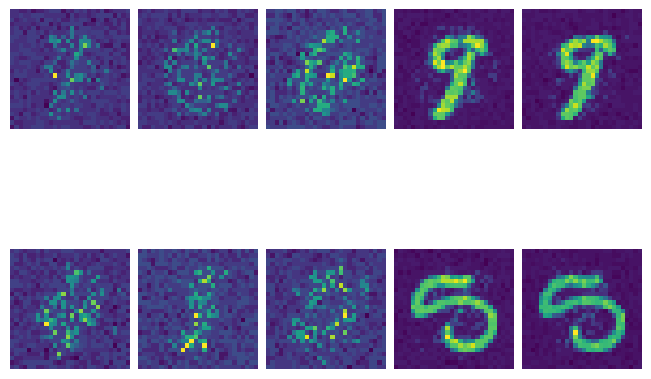

In [7]:
data, target = next(iter(loaders[0]))
temporal_data, _ = process_data(data, data_config)
if data_config["common_input"]:
    temporal_data = torch.stack(
        temporal_data.split(temporal_data.shape[-1] // n_agents, -1), 1
    )

fig, axs = plt.subplots(n_agents, temporal_data.shape[0], constrained_layout=True)
for t_data, t_axs in zip(temporal_data, axs.T):
    for d, ax in zip(t_data, t_axs):
        ax.imshow(d[0].cpu().numpy().reshape(28, 28))
        ax.axis("off")


## Init Models

In [10]:
from dynspec.models import masked_GRU, masked_RNN, Community

In [107]:
task = ["parity-digits", "inv-parity-digits"]
task = ['0', '1']
n_hidden = 50

agents_config = {
    "n_agents": 2,
    "hidden_size": n_hidden,
    "n_layers": 1,
    "dropout": 0.25,
    "cell_type": str(masked_RNN),
}

n_conns = 2
connections_config = {"sparsity": n_conns / agents_config["hidden_size"] ** 2}

n_outs = {
    'none' : [10, 10],
    "parity-digits": 10,
    "inv-parity-digits": 10,
    "parity-digits-both": [10, 10],
    "parity-digits-sum": 2,
    "sum": 20,
    "bitxor": 16,
    "bitxor-last-1": 2,
    '1' : 10,
    '0' : 10,
    'inv' : 10
}

input_config = {"input_size": data_config["input_size"] ** 2, "common_input": False}
optim_config = {"lr": 1e-3, "weight_decay": 1e-4}

readout_config = {
    "output_size": n_outs[task]
    if not isinstance(task, list)
    else [n_outs[t] for t in task],
    "common_readout": False,
}

decision = ["last", "both"]

training_config = {
    "n_epochs": 30,
    "task": task,
}

config = {
    "agents": agents_config,
    "connections": connections_config,
    "input": input_config,
    "readout": readout_config,
    "data": data_config,
    "decision": decision,
    "training": training_config,
    "optim": optim_config,
}

In [108]:
def find_and_change(config, param_name, param_value):
    for key, value in config.items():
        if type(value) is dict:
            find_and_change(value, param_name, param_value)
        else:
            if key == param_name:
                config[key] = param_value

    return config


def copy_and_change_config(config, varying_params):
    config = copy.deepcopy(config)
    for n, v in varying_params.items():
        find_and_change(config, n, v)

    return config

def get_all_v_params(varying_params, excluded_params={}):
    return [
        {
            k: p
            for k, p in zip(varying_params.keys(), params)
            if k not in excluded_params
        }
        for params in product(*varying_params.values())
    ]

In [109]:
# n_conns = np.unique(np.round(np.geomspace(1, n_hidden**2, 10, dtype=int) / n_hidden**2, 4))
n_conns = np.array([0, n_hidden**2]) / n_hidden**2
varying_params = {
    "sparsity": n_conns[::-1]
}
all_varying_params = get_all_v_params(varying_params)
configs = [copy_and_change_config(config, p) for p in all_varying_params]
n_conns

array([0., 1.])

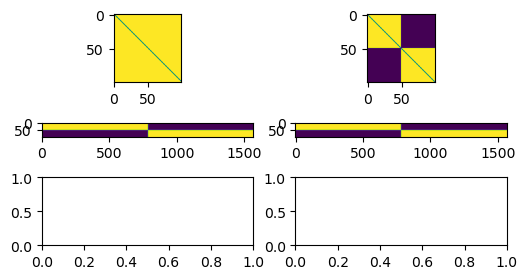

In [110]:
models = [Community(config).to(device) for config in configs]

optimizers = [
    torch.optim.AdamW(model.parameters(), **config["optim"])
    for model, config in zip(models, configs)
]
fig, axs = plt.subplots(3, len(models), figsize=(len(models)*3, 3))
[ax.imshow((model.masks['comms_mask'] + model.masks['rec_mask']).cpu().numpy()) for model, ax in zip(models, axs[0])];
[ax.imshow((model.masks['input_mask']).cpu().numpy()) for model, ax in zip(models, axs[1])];
# [ax.imshow((model.masks['output_mask']).cpu().numpy()) for model, ax in zip(models, axs[2])];


## Training

In [111]:
from dynspec.training import train_community, get_acc, get_loss
from dynspec.decision import get_decision
from dynspec.tasks import get_task_target

In [112]:
data, target = next(iter(loaders[1]))
data, _ = process_data(data, data_config)
data, target = data.to(device), target.to(device)
out, _ = models[0](data)

In [113]:
output, _ = get_decision(out, *decision)
t_target = get_task_target(target, task, data_config["n_classes_per_digit"])
get_acc(output, t_target, use_both=decision[1] == 'both')[0]


array([[0.07226562, 0.10742188],
       [0.08984375, 0.09179688]], dtype=float32)

In [115]:
parallel = False

import multiprocess as mp
import multiprocess.context as ctx
ctx._force_start_method('spawn')

def train(params):
    
    model, optimizer, config, use_tqdm, loaders = params
    from dynspec.training import train_community
    import torch
    use_cuda = torch.cuda.is_available()
    
    return train_community(
        model,
        optimizer,
        config,
        loaders=loaders,
        stop_acc=0.95,
        device=torch.device("cuda" if use_cuda else "cpu"),
        show_all_acc=False,
        use_tqdm=use_tqdm,
    )

if parallel:
    try : 
            
        pool = mp.Pool(processes=len(models))
        train_results = pool.map(
            train,
            zip(
                models,
                optimizers,
                configs,
                [i == len(configs) - 1 for i in range(len(configs))],
                [copy.deepcopy(loaders) for _ in configs],
            ),
        )
    finally :
        pool.close()
else : 
    train_results = [
    train_community(
        model,
        optimizer,
        config,
        loaders,
        stop_acc=0.95,
        device=device,
        show_all_acc=True,
        n_epochs=5
    )
    for model, optimizer, config in zip(models, optimizers, configs)
]

Train Epoch::   0%|          | 0/6 [00:00<?, ?it/s]

/home/gb21/.conda/envs/dynspec/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gb21/.conda/envs/dynspec/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Train Epoch::   0%|          | 0/6 [00:00<?, ?it/s]

### Results

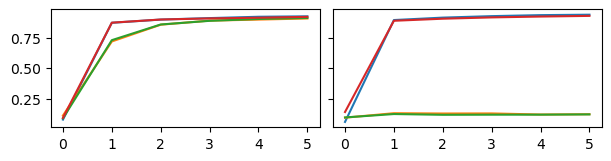

In [131]:
from math import sqrt, ceil
n1, n2 = int(sqrt(len(configs))), int(ceil(sqrt(len(configs))))

fig, axs = plt.subplots(
    n1, n2, figsize=(3 * n2, n1*1.5), constrained_layout=True, sharey=True, sharex=True
)
    
[ax.plot(t["test_accs"].reshape(t['test_accs'].shape[0], -1)) for t, ax in zip(train_results, axs.flatten())];


In [20]:
raise StopIteration


StopIteration: 

### Analysis

In [ ]:
data, target = next(iter(loaders[1]))
data, _ = process_data(data, data_config)
data.shape
out, states = model(data.to(device))
out.shape, states.shape
t_target = get_task_target(target, task, data_config["n_classes_per_digit"])


In [ ]:
comms_sent = states[
    ...,
    (model.comms_mask.split(100, 0)[0] * (1 - model.state_mask.split(100, 0)[0]))
    .to(bool)
    .any(1),
][-1]
comms_received = states[
    ...,
    (model.comms_mask.split(100, 0)[0] * (1 - model.state_mask.split(100, 0)[0]))
    .to(bool)
    .any(0),
][-1]


In [ ]:
comms_sent.shape


torch.Size([512, 2])

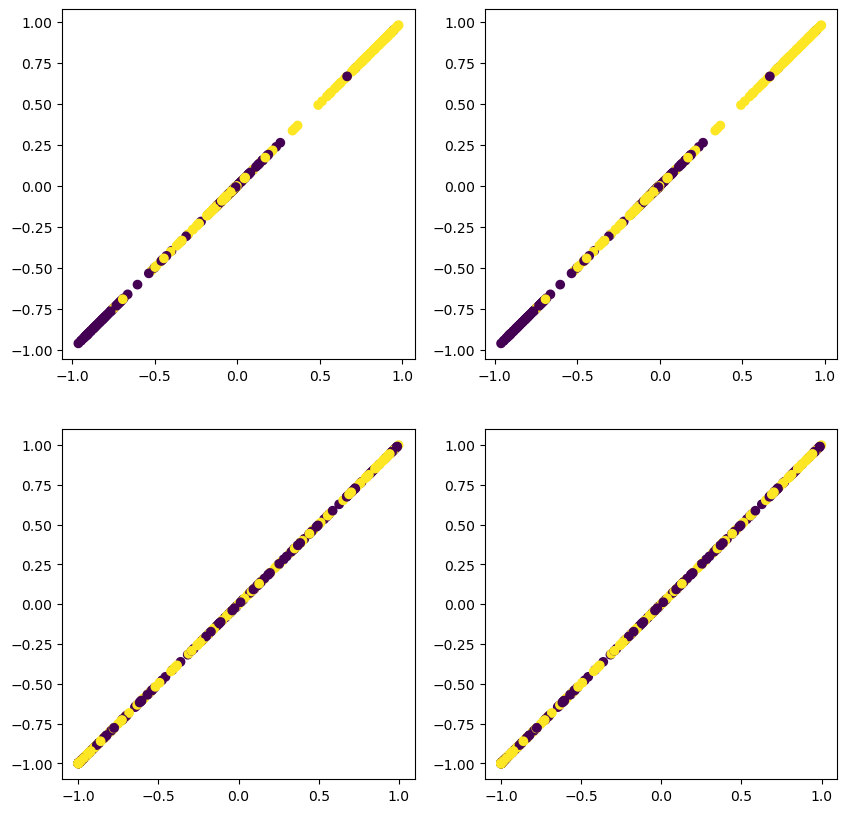

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
try:
    axs[0]
except TypeError:
    axs = np.array([axs])
for comms, axs_c in zip([comms_sent, comms_received], axs):
    try:
        axs_c[0]
    except TypeError:
        axs_c = np.array([axs_c])
    for (i, j), ax in zip(product(range(2), repeat=2), axs_c.flatten()):
        try:
            ax.scatter(
                comms[:, 2 * i].cpu().data.numpy(),
                comms[:, 2 * i].cpu().data.numpy(),
                c=t_target,
            )
        except IndexError:
            ax.scatter(
                range(len(comms[:, i])), comms[:, i].cpu().data.numpy(), c=t_target
            )


## Metrics

### Retraining

In [132]:
def readout_mask(n_agents, n_in, n_out, ag_to_mask=None):
    mask = torch.ones(n_agents).unsqueeze(0)
    if ag_to_mask is not None:
        mask[:, ag_to_mask] = 0
    mask = mask.repeat_interleave(n_out, 0).repeat_interleave(n_in, 1)
    # plt.imshow(mask)
    return mask

n_classes = config["data"]["n_classes_per_digit"]
n_targets = 2

def nested_shape(output):
    if hasattr(output, "shape"):
        return [output.shape]
    else:
        return [nested_shape(o) for o in output]


def reccursive_loss(output, target, loss_fn):
    try:
        out = loss_fn(output, target)

        # out = torch.stack(out)
    except (TypeError, RuntimeError) as e:
        out = [reccursive_loss(o, t, loss_fn) for o, t in zip(output, target)]

    return out


def reccursive_stack(input):
    try:
        return torch.stack(input)
    except TypeError:
        return torch.stack([reccursive_stack(i) for i in input])

In [161]:
retraining_configs = [config.copy() for config in configs]
retraining_models = [copy.deepcopy(model) for model in models]

for retraining_config, model in zip(retraining_configs, retraining_models):
    retraining_config["readout"]["n_hid"] = 30
    model.readout = nn.ModuleList(
        [
            nn.ModuleList(
                [
                    nn.Sequential(
                        *[
                            nn.Linear(
                                model.n_agents * model.hidden_size,
                                retraining_config["readout"]["n_hid"],
                            ),
                            nn.ReLU(),
                            nn.Linear(retraining_config["readout"]["n_hid"], n_classes),
                        ]
                    )
                    if retraining_config["readout"]["n_hid"]
                    else nn.Linear(model.n_agents * model.hidden_size, n_classes)
                    for _ in range(3)
                ]
            )
            for _ in range(n_targets)
        ]
    )

    for n, p in model.named_parameters():
        if not "readout" in n:
            p.requires_grad = False
        else:
            p.requires_grad = True
    model.register_buffer(
        "output_mask",
        torch.stack(
            [
                torch.stack(
                    [
                        readout_mask(
                            model.n_agents,
                            model.hidden_size,
                            retraining_config["readout"]["n_hid"],
                            ag_to_mask=i,
                        )
                        if retraining_config["readout"]["n_hid"] is not None
                        else readout_mask(
                            model.n_agents, model.hidden_size, n_classes, ag_to_mask=1-i
                        )
                        for i in list(range(model.n_agents))[::-1] + [None]
                    ]
                )
                for _ in range(n_targets)
            ]
        ),
    )

    model.to(device)

    retraining_config["decision"] = ("none", "none")
    retraining_config["training"]["task"] = [
        [[str(i) for i in range(n_agents)] for _ in range(3)] for _ in range(nb_steps)
    ]
    model.output_size = [[10 for i in list(range(model.n_agents))[::-1] + [None]] for _ in range(n_targets)]
    # retraining_config["training"]["task"] = [
    #     [str(i) for _ in range(3)] for i in range(n_agents)
    # ]
    retraining_config["training"]["n_epochs"] = 10

retraining_optimizers = [
    torch.optim.AdamW(retraining_model.parameters(), **config["optim"])
    for retraining_model, config in zip(retraining_models, configs)
]

In [162]:
t_target = get_task_target(
    target.to(device), retraining_config["training"]["task"], n_classes_per_digit
)

In [163]:
outs, _ = retraining_models[0](data)
outs = get_decision(outs, *retraining_configs[0]["decision"])[0]


In [164]:
outs.shape

torch.Size([5, 3, 2, 512, 10])

In [165]:
accs, correct = get_acc(outs, t_target)
losses = get_loss(outs, t_target)
print(accs.shape, losses.shape, correct.shape)


(5, 3, 2) torch.Size([5, 3, 2, 512]) (5, 3, 2, 512)


In [167]:
if parallel:
    pool = mp.Pool(processes=len(models))
    retrain_results = pool.map(
        train,
        zip(
            retraining_models,
            retraining_optimizers,
            retraining_configs,
            [i == len(retraining_configs) - 1 for i in range(len(retraining_configs))],
            [copy.deepcopy(loaders) for _ in retraining_configs],
        ),
    )

else:
    retrain_results = [
        train_community(
            retraining_model,
            retraining_optimizer,
            retraining_config,
            loaders,
            stop_acc=0.95,
            device=device,
            show_all_acc=False
        )
        for retraining_model, retraining_optimizer, retraining_config in zip(
            retraining_models, retraining_optimizers, retraining_configs
        )
    ]

Train Epoch::   0%|          | 0/11 [00:00<?, ?it/s]

/home/gb21/.conda/envs/dynspec/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gb21/.conda/envs/dynspec/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Train Epoch::   0%|          | 0/11 [00:00<?, ?it/s]

In [168]:
metric_norm = lambda m: np.clip(m - 0.1 / (1 - 0.1), 0, 1)
diff_metric = lambda metric: (metric[0] - metric[1]) / (
    (metric[0]) + (metric[1])
)
global_diff_metric = (
    lambda metric: np.abs(diff_metric(metric[0]) - diff_metric(metric[1])) / 2
)

det = lambda M: np.abs(np.linalg.det(M))
diff_metric = lambda col: (col[0] - col[1]) / col.sum()
normed_det = lambda M: det(M) / M.sum(0).prod()

In [173]:
retrain_accs = [metric_norm(r["test_accs"][-1]) for r in retrain_results]
retrain_all_accs = [metric_norm(r["all_accs"][-1]) for r in retrain_results]

In [180]:
retrain_global_data = {k: [] for k in ["metric", "n_conns", "step"]}
for r_accs, conns in zip(retrain_accs, n_conns):
    retrain_global_data["metric"].extend(global_diff_metric(r) for r in r_accs)
    retrain_global_data["n_conns"].extend([conns] * len(r_accs))
    retrain_global_data["step"].extend(range(len(r_accs)))

/tmp/ipykernel_73882/593218122.py:10: RuntimeWarning: invalid value encountered in scalar divide
  diff_metric = lambda col: (col[0] - col[1]) / col.sum()


In [181]:
import seaborn as sns
import pandas as pd


<Axes: xlabel='step', ylabel='metric'>

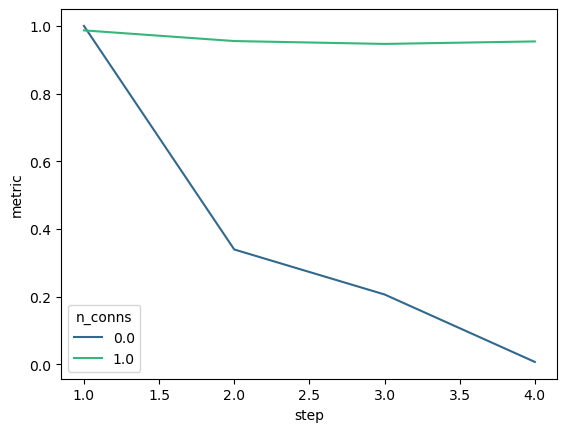

In [183]:
sns.lineplot(data=retrain_global_data, x="step", y="metric", hue="n_conns", palette='viridis')


In [184]:
retrain_ag_data = {k: [] for k in ["metric", "n_conns", "step", "ag"]}

for r_accs, conns in zip(retrain_accs, n_conns):
    for step, s_accs in enumerate(r_accs):
        for ag, ag_accs in enumerate(s_accs[:2]):
            retrain_ag_data["metric"].append(diff_metric(ag_accs))
            retrain_ag_data["n_conns"].append(conns)
            retrain_ag_data["step"].append(step)
            retrain_ag_data["ag"].append(ag)

retrain_ag_data = pd.DataFrame.from_dict(retrain_ag_data)

/tmp/ipykernel_73882/593218122.py:10: RuntimeWarning: invalid value encountered in scalar divide
  diff_metric = lambda col: (col[0] - col[1]) / col.sum()


<Axes: xlabel='step', ylabel='metric'>

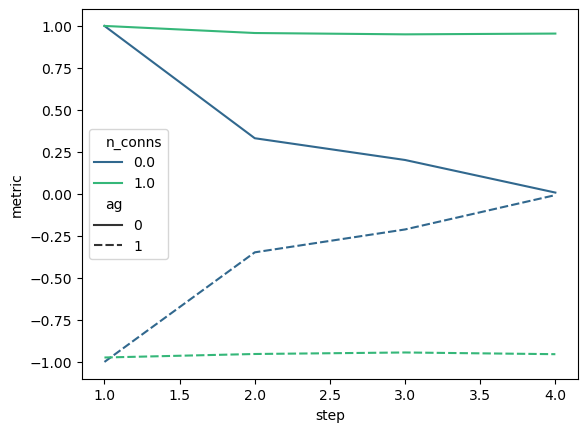

In [185]:
sns.lineplot(
    data=retrain_ag_data,
    x="step",
    y="metric",
    hue="n_conns",
    style="ag",
    palette="viridis",
)

### Random Timings

In [186]:
from tqdm.notebook import tqdm

In [187]:
all_outputs = []
all_start_times = []
all_targets = []

for net, config in zip(tqdm(retraining_models), retraining_configs):
    all_outputs.append([])
    all_start_times.append([])
    all_targets.append([])

    for data, target in loaders[1]:
        data, start_times = process_data(
            data,
            config['data']
        )
        data, target = data.to(device), target.to(device)

        outputs, _ = net(data)
        outputs = [o[:2] for o in outputs]
        all_outputs[-1].append(outputs)
        all_start_times[-1].append(start_times)
        all_targets[-1].append(target)

all_outputs, all_start_times, all_targets = [
    {n_s: torch.cat([o for o in reccursive_stack(r)], -2) for n_s, r in zip(n_conns, all_r)}
    for all_r in [all_outputs, all_start_times, all_targets]
]

  0%|          | 0/2 [00:00<?, ?it/s]

In [188]:
all_accs = {
    n_s: np.stack(
        [get_acc(o.transpose(0, 1), [t for _ in range(nb_steps)], use_both=True)[1] for o, t in zip(all_o, all_t.T)], 1
    )
    for (n_s, all_o), all_t in zip(all_outputs.items(), all_targets.values())
}

In [189]:
all_accs[n_conns[0]].shape

(5, 2, 2, 7680)

In [190]:
all_u_masks = {
    n_s: np.array([(all_start == u).all(-1) for u in all_start.unique(dim=0)])
    for n_s, all_start in all_start_times.items()
}

In [191]:
all_u_masks[n_conns[0]]

array([[False,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False]])

In [192]:
plot_data = {
    "t0": [],
    "t1": [],
    "t0_t1": [],
    "step": [],
    "local_metric": [],
    "ag": [],
    "n_conns": [],
}

for n_s in all_accs.keys():
    # for u_masks, accs, start_times in zip(
    #     all_u_masks[n_s], all_accs[n_s], all_start_times[n_s]
    # ):
    u_masks, accs, start_times = all_u_masks[n_s], all_accs[n_s], all_start_times[n_s]
    for mask, pair in zip(u_masks, start_times.unique(dim=0)):
        for step in range(accs.shape[0]):
            for ag in range(n_agents):
                # plot_data['global_metric'].append(diff_metric(all_accs[step, -1, :, mask].mean(0)))
                plot_data["local_metric"].append(
                    diff_metric(accs[step, ag, :, mask].mean(0))
                )
                # plot_data['local_metric_1'].append(diff_metric(all_accs[step, 1, :, mask].mean(0)))
                plot_data["t0"].append(pair[0].item())
                plot_data["t1"].append(pair[1].item())
                plot_data["t0_t1"].append(tuple(pair.cpu().data.numpy()))
                plot_data["step"].append(step)
                plot_data["ag"].append(ag)
                plot_data["n_conns"].append(n_s)
                # plot_data['x'].append([-1, 1][ag] * (accs.shape[0] - step))
                # plot_data['x'].append(step)

        # plot_data['local_metric'].append(diff_metric(accs[step, -1, :, mask].mean(0)))
        # plot_data['t0'].append(pair[0].item())
        # plot_data['t1'].append(pair[1].item())
        # plot_data['t0_t1'].append(tuple(pair.cpu().data.numpy()))
        # plot_data['step'].append(nb_steps)
        # plot_data['ag'].append(-1)

plot_data = pd.DataFrame.from_dict(plot_data)

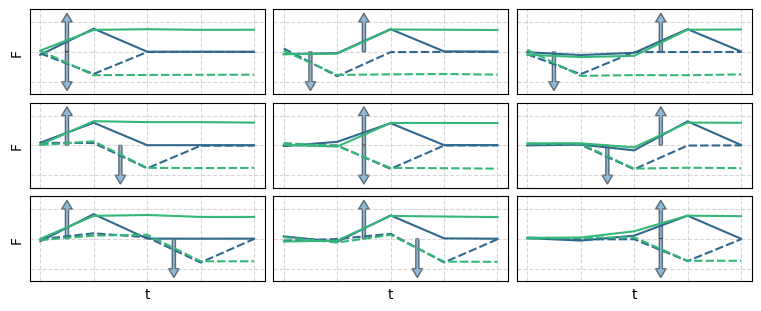

In [194]:
fig, axs = plt.subplots(3, 3, figsize=(3 * 2.5, 3 * 1), constrained_layout=True)
for u, ax in zip(plot_data["t0_t1"].unique(), axs.T.flatten()):
    t0, t1 = u
    sns.lineplot(
        plot_data[plot_data["t0_t1"] == u],
        y="local_metric",
        x="step",
        ax=ax,
        style="ag",
        hue="n_conns",
        palette="viridis",
    )
    # ax.vlines(x = [t0 - 0.5 ], ymin = -1, ymax = 1, color = 'blue', alpha = .2)
    # ax.vlines(x = [t1 - 0.5 ], ymin = -1, ymax = 1, color = 'red', alpha = .2)
    ax.arrow(t0 - 0.5, 0, 0, 1, alpha=0.5, width=0.06, head_width=0.2)
    ax.arrow(t1 - 0.5, 0, 0, -1, alpha=0.5, width=0.06, head_width=0.2)
    ax.legend()
    # ax.set_title(u)

    if t1 == 3:
        ax.set_xlabel("t")
    else:
        ax.set_xlabel("")

    if t0 == 1:
        ax.set_ylabel("F")
    else:
        ax.set_ylabel("")

    ax.legend().remove()
    ax.grid(visible=True, linestyle="--", alpha=0.5)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)
    for tick in ax.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)

# fig.savefig(f"../../results/imgs/random_noisy_timings.svg")